In [75]:
import warnings
warnings.filterwarnings("ignore")

In [76]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os

import cv2
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from PIL import Image

from cycler import cycler
gruvbox_colors = [
    "#fb4934",  # red
    "#fabd2f",  # yellow
    "#b8bb26",  # green
    "#83a598",  # blue
    "#d3869b",  # purple
    "#fe8019",  # orange
    "#8ec07c",  # aqua
]
rc = {
    "axes.facecolor": "#282828",
    "figure.facecolor": "#282828",
    "axes.edgecolor": "#3c3836",
    "grid.color": "#504945",
    "font.family": "arial",
    "axes.labelcolor": "#ebdbb2",
    "xtick.color": "#d5c4a1",
    "ytick.color": "#d5c4a1",
    "grid.alpha": 0.3,
    "axes.prop_cycle": cycler(color=gruvbox_colors),
}
sns.set(rc=rc, style="darkgrid")

In [77]:
base_dir = "/kaggle/input/fer2013"
for split in ["train", "test"]:
    print(f"{split} set classes:", os.listdir(os.path.join(base_dir, split)))

train set classes: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']
test set classes: ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']


# Data Loading

In [78]:
# custom dataset class
class FER2013Dataset(torch.utils.data.Dataset):
    """
    Custom class for loading the FER2013 emotion dataset

    Each subdirectory in `base_dir` represents one emotion class
    (e.g., 'happy', 'sad', 'neutral'), and contatins multiple grayscale face images
    of size roughly 48x48 pixels

    This class provides:
    - Automatic class label mapping (folder name = numeric index)
    - Image loading via OpenCV
    - Optional preprocessing and augmentation via tochvision transform
    """
    
    def __init__(self, base_dir, transform=None):
        """
        @input
            base dir (str): path to dataset root
            transform (callable, optional): torchvision transform pipeline to apply
        """
        self.base_dir = base_dir
        self.transform = transform
        self.samples = [] # list of (image_path, class_label) pairs
        self.classes = sorted(os.listdir(base_dir))

        # build list of all image paths + their corresponding numeric labels
        for label, cls in enumerate(self.classes):
            cls_dir = os.path.join(base_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(cls_dir, img_name), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        @return
            img (torch.Tensor): preprocessed img tensor [1, 48, 48]
            label (int): class inx corresponding to the emotion category
        """
        path, label = self.samples[idx]
        # img from disk -> 2D NumPy array
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48, 48))

        if self.transform:
            img = self.transform(img)

        return img, label

In [79]:
class CustomAugment:
    """
    Custom data augmentation tailored for webcam-based face emotion recognition

    It simulates realisitc variations:
        - Small head tilts (rotation)
        - Left/right mirroring
        - Lighting changes (brightness)
    """

    def __init__(self, rotation=15, flip_prob=0.5, brightness=0.2, brightness_prob=0.3):
        self.rotation = rotation
        self.flip_prob = flip_prob
        self.brightness = brightness
        self.brightness_prob = brightness_prob

    def __call__(self, img):
        """
        @input
            img (numpy.ndarray): grayscale img loaded via OpenCV
        @return
            PIL.Image: augmented img
        """
        img = Image.fromarray(img)

        angle = random.uniform(-self.rotation, self.rotation)
        img = transforms.functional.rotate(img, angle)

        if random.random() < self.flip_prob:
            img = transforms.functional.hflip(img)

        if random.random() < self.brightness_prob:
            factor = 1 + random.uniform(-self.brightness, self.brightness)
            img = transforms.functional.adjust_brightness(img, factor)

        return img

In [80]:
train_transform = transforms.Compose([
    CustomAugment(rotation=15, flip_prob=0.5, brightness=0.2, brightness_prob=0.35),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Quick Visualization

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

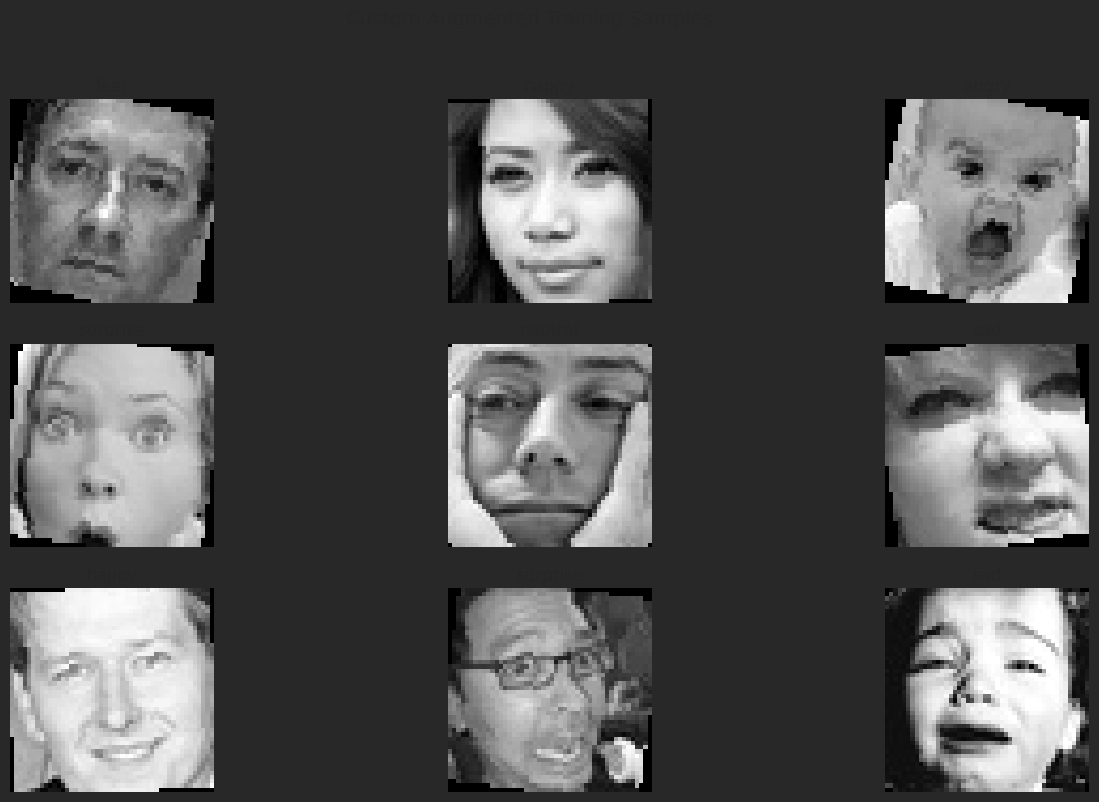

In [81]:
train_dataset = FER2013Dataset('/kaggle/input/fer2013/train', transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=9, shuffle=True) # wrap it

images, labels = next(iter(train_loader))
images = images * 0.5 + 0.5 # denormalize to [0, 1] for plotting

plt.figure(figsize=(16, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(train_dataset.classes[labels[i]])
    plt.axis('off')

plt.suptitle("Custom Augmented Training Samples", fontsize=14)
plt.show()

In [82]:
# custom dataset class
class FER2013Dataset(torch.utils.data.Dataset):
    """
    Custom class for loading the FER2013 emotion dataset

    Each subdirectory in `base_dir` represents one emotion class
    (e.g., 'happy', 'sad', 'neutral'), and contatins multiple grayscale face images
    of size roughly 48x48 pixels

    We only want three classes to keep for training:
        0: Happy
        1: Sad
        2: Neutral (all other emotions)

    This class provides:
        - Automatic remapping of folder names to numeric labels
        - Image loading via OpenCV
        - Optional preprocessing and augmentation via torchvision transforms
    """
    
    def __init__(self, base_dir, transform=None):
        """
        @input
            base dir (str): path to dataset root
            transform (callable, optional): torchvision transform pipeline to apply
        """
        self.base_dir = base_dir
        self.transform = transform
        self.samples = [] # list of (image_path, class_label) pairs
        self.classes = sorted(os.listdir(base_dir))

        # build list of all image paths + remapped labels
        for cls in self.classes:
            cls_dir = os.path.join(base_dir, cls)
            if cls.lower() == "happy":
                label = 0
            elif cls.lower() == "sad":
                label = 1
            else:
                label = 2 # everything else = neutral

            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(cls_dir, img_name), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        @return
            img (torch.Tensor): preprocessed img tensor [1, 48, 48]
            label (int): class inx corresponding to the emotion category
        """
        path, label = self.samples[idx]
        
        # img from disk -> 2D NumPy array
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        # resize
        img = cv2.resize(img, (48, 48))

        if self.transform:
            img = self.transform(img)

        return img, label

Compose Transforms

In [83]:
train_transform = transforms.Compose([
    CustomAugment(rotation=15, flip_prob=0.5, brightness=0.20, brightness_prob=0.35),
    # could add small extra torchvision augmentations later
    
    transforms.ToTensor(), # PIL -> tensor [C, H, W], scales [0..255] -> [0..1]
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Instantiate Dataset and Loaders

In [84]:
train_dataset = FER2013Dataset('/kaggle/input/fer2013/train', transform=train_transform)
test_dataset = FER2013Dataset('/kaggle/input/fer2013/test',  transform=test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

Train size: 28709
Test size: 7178


findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.


Labels in this batch:
['Neutral', 'Sad', 'Neutral', 'Neutral', 'Neutral', 'Happy', 'Neutral', 'Neutral', 'Happy']


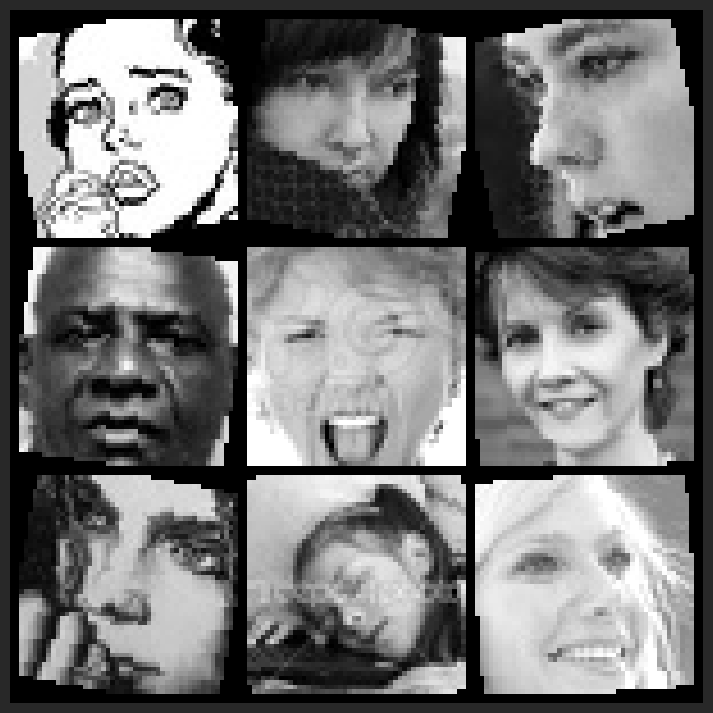

In [85]:
# Remapped label names
label_names = ["Happy", "Sad", "Neutral"]

def show_augmented_batch(loader, n=9):
    # grab first batch
    images, labels = next(iter(loader))
    
    images = images * 0.5 + 0.5  # denormalize to [0,1]

    # pick first n images and labels
    images = images[:n]
    labels = labels[:n]

    grid = torchvision.utils.make_grid(images, nrow=int(n**0.5), normalize=False)
    plt.figure(figsize=(16,9))
    plt.imshow(grid.permute(1,2,0).squeeze())
    plt.axis('off')

    # print labels below grid
    print("Labels in this batch:")
    print([label_names[label.item()] for label in labels])

    plt.show()

# Show a batch
show_augmented_batch(train_loader, n=9)

# Build Model

In [86]:
import torch.nn as nn
import torch.nn.functional as F


class MyCNN(nn.Module):
    """
    Mid-size CNN for 48x48 grayscale facial expression classification 3 output classes:
    Happy, Sad, Neutral
    """
    def __init__(self, num_classes=3):
        super().__init__()

        # -- Conv Blocks --
        # Hierarchical feature learning 
        # Conv Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), # 48x48 -> 24x24
            nn.Dropout(0.1)
        )

        # Conv Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # 24x24 -> 12x12
            nn.Dropout(0.1)
        )

        # Conv block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), # 12x12 -> 6x6
            nn.Dropout(0.25)
        )

        # Adaptive pooling to reduce to (1x1) features per channel
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    # forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.global_pool(x)
        x = self.fc(x)
        return x

# Train

In [87]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0)/1024**3,1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0)/1024**3,1), "GB")

model = MyCNN().to(device)
num_epochs = 50
best_val_acc = 0.0

criterion = nn.CrossEntropyLoss()
# AdamW is generally more stable than Adam and supports weight decay properly
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
# Reduce LR when validation accuracy plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# TensorBoard writer for live monitoring
writer = SummaryWriter('runs/mimic_exp1')

Using device: cuda
Tesla T4
Memory Usage:
Allocated: 0.6 GB
Cached:    1.5 GB


Split Into train / val

In [88]:
from torch.utils.data import random_split

val_size = int(0.1 * len(train_dataset)) # 10% for val
train_size = len(train_dataset) - val_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Wrap them in DataLoader
train_loader = DataLoader(
    train_subset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_subset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

Training Loop Skeleton

In [89]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    # Training Loop
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = total_loss / len(train_loader)

    # save losses for plots
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_correct, val_total = 0, 0
    val_loss = 0.0

    # disable gradient computation here
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # save losses for plots
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Learning rate schedule
    scheduler.step(val_acc)

    # TensorBoard logging | not useful for kaggle env but good locally
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)
    writer.add_scalar("LR", optimizer.param_groups[0]['lr'], epoch)

    # Checkpointing model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} ")

writer.close()

Epoch 1/50: 100%|██████████| 101/101 [01:00<00:00,  1.68it/s]


Epoch [1/50] Train Loss: 0.9474 | Train Acc: 0.5784 Val Loss: 0.8750 | Val Acc: 0.6223 


Epoch 2/50: 100%|██████████| 101/101 [00:20<00:00,  4.96it/s]


Epoch [2/50] Train Loss: 0.8188 | Train Acc: 0.6483 Val Loss: 0.8502 | Val Acc: 0.6275 


Epoch 3/50: 100%|██████████| 101/101 [00:20<00:00,  5.05it/s]


Epoch [3/50] Train Loss: 0.7188 | Train Acc: 0.6976 Val Loss: 0.6846 | Val Acc: 0.7094 


Epoch 4/50: 100%|██████████| 101/101 [00:20<00:00,  4.96it/s]


Epoch [4/50] Train Loss: 0.6787 | Train Acc: 0.7131 Val Loss: 0.6790 | Val Acc: 0.7122 


Epoch 5/50: 100%|██████████| 101/101 [00:20<00:00,  4.90it/s]


Epoch [5/50] Train Loss: 0.6499 | Train Acc: 0.7263 Val Loss: 0.6763 | Val Acc: 0.7174 


Epoch 6/50: 100%|██████████| 101/101 [00:20<00:00,  4.98it/s]


Epoch [6/50] Train Loss: 0.6340 | Train Acc: 0.7299 Val Loss: 0.6165 | Val Acc: 0.7443 


Epoch 7/50: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s]


Epoch [7/50] Train Loss: 0.6222 | Train Acc: 0.7378 Val Loss: 0.6014 | Val Acc: 0.7488 


Epoch 8/50: 100%|██████████| 101/101 [00:20<00:00,  4.96it/s]


Epoch [8/50] Train Loss: 0.6135 | Train Acc: 0.7370 Val Loss: 0.6110 | Val Acc: 0.7523 


Epoch 9/50: 100%|██████████| 101/101 [00:20<00:00,  4.95it/s]


Epoch [9/50] Train Loss: 0.6024 | Train Acc: 0.7463 Val Loss: 0.6326 | Val Acc: 0.7321 


Epoch 10/50: 100%|██████████| 101/101 [00:20<00:00,  4.89it/s]


Epoch [10/50] Train Loss: 0.5905 | Train Acc: 0.7486 Val Loss: 0.5987 | Val Acc: 0.7481 


Epoch 11/50: 100%|██████████| 101/101 [00:20<00:00,  4.88it/s]


Epoch [11/50] Train Loss: 0.5874 | Train Acc: 0.7528 Val Loss: 0.6668 | Val Acc: 0.7491 


Epoch 12/50: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s]


Epoch [12/50] Train Loss: 0.5801 | Train Acc: 0.7529 Val Loss: 0.5667 | Val Acc: 0.7589 


Epoch 13/50: 100%|██████████| 101/101 [00:20<00:00,  4.94it/s]


Epoch [13/50] Train Loss: 0.5733 | Train Acc: 0.7573 Val Loss: 0.6974 | Val Acc: 0.6916 


Epoch 14/50: 100%|██████████| 101/101 [00:21<00:00,  4.76it/s]


Epoch [14/50] Train Loss: 0.5649 | Train Acc: 0.7601 Val Loss: 0.5884 | Val Acc: 0.7432 


Epoch 15/50: 100%|██████████| 101/101 [00:21<00:00,  4.79it/s]


Epoch [15/50] Train Loss: 0.5574 | Train Acc: 0.7626 Val Loss: 0.6300 | Val Acc: 0.7512 


Epoch 16/50: 100%|██████████| 101/101 [00:21<00:00,  4.72it/s]


Epoch [16/50] Train Loss: 0.5540 | Train Acc: 0.7640 Val Loss: 0.5698 | Val Acc: 0.7512 


Epoch 17/50: 100%|██████████| 101/101 [00:20<00:00,  4.81it/s]


Epoch [17/50] Train Loss: 0.5358 | Train Acc: 0.7707 Val Loss: 0.5387 | Val Acc: 0.7753 


Epoch 18/50: 100%|██████████| 101/101 [00:21<00:00,  4.80it/s]


Epoch [18/50] Train Loss: 0.5301 | Train Acc: 0.7740 Val Loss: 0.5418 | Val Acc: 0.7700 


Epoch 19/50: 100%|██████████| 101/101 [00:20<00:00,  4.91it/s]


Epoch [19/50] Train Loss: 0.5298 | Train Acc: 0.7757 Val Loss: 0.5215 | Val Acc: 0.7725 


Epoch 20/50: 100%|██████████| 101/101 [00:21<00:00,  4.81it/s]


Epoch [20/50] Train Loss: 0.5229 | Train Acc: 0.7771 Val Loss: 0.5364 | Val Acc: 0.7662 


Epoch 21/50: 100%|██████████| 101/101 [00:20<00:00,  4.84it/s]


Epoch [21/50] Train Loss: 0.5175 | Train Acc: 0.7782 Val Loss: 0.5294 | Val Acc: 0.7826 


Epoch 22/50: 100%|██████████| 101/101 [00:20<00:00,  4.99it/s]


Epoch [22/50] Train Loss: 0.5182 | Train Acc: 0.7786 Val Loss: 0.5812 | Val Acc: 0.7721 


Epoch 23/50: 100%|██████████| 101/101 [00:20<00:00,  4.88it/s]


Epoch [23/50] Train Loss: 0.5124 | Train Acc: 0.7838 Val Loss: 0.5239 | Val Acc: 0.7812 


Epoch 24/50: 100%|██████████| 101/101 [00:20<00:00,  4.93it/s]


Epoch [24/50] Train Loss: 0.5115 | Train Acc: 0.7818 Val Loss: 0.5591 | Val Acc: 0.7721 


Epoch 25/50: 100%|██████████| 101/101 [00:20<00:00,  4.91it/s]


Epoch [25/50] Train Loss: 0.5067 | Train Acc: 0.7831 Val Loss: 0.5387 | Val Acc: 0.7829 


Epoch 26/50: 100%|██████████| 101/101 [00:21<00:00,  4.66it/s]


Epoch [26/50] Train Loss: 0.5070 | Train Acc: 0.7846 Val Loss: 0.5207 | Val Acc: 0.7767 


Epoch 27/50: 100%|██████████| 101/101 [00:20<00:00,  4.82it/s]


Epoch [27/50] Train Loss: 0.5019 | Train Acc: 0.7879 Val Loss: 0.5364 | Val Acc: 0.7868 


Epoch 28/50: 100%|██████████| 101/101 [00:20<00:00,  4.91it/s]


Epoch [28/50] Train Loss: 0.5002 | Train Acc: 0.7877 Val Loss: 0.5613 | Val Acc: 0.7774 


Epoch 29/50: 100%|██████████| 101/101 [00:21<00:00,  4.81it/s]


Epoch [29/50] Train Loss: 0.4993 | Train Acc: 0.7893 Val Loss: 0.5472 | Val Acc: 0.7714 


Epoch 30/50: 100%|██████████| 101/101 [00:21<00:00,  4.74it/s]


Epoch [30/50] Train Loss: 0.4935 | Train Acc: 0.7901 Val Loss: 0.5190 | Val Acc: 0.7711 


Epoch 31/50: 100%|██████████| 101/101 [00:20<00:00,  4.89it/s]


Epoch [31/50] Train Loss: 0.4917 | Train Acc: 0.7930 Val Loss: 0.5268 | Val Acc: 0.7742 


Epoch 32/50: 100%|██████████| 101/101 [00:20<00:00,  4.98it/s]


Epoch [32/50] Train Loss: 0.4796 | Train Acc: 0.7970 Val Loss: 0.5060 | Val Acc: 0.7829 


Epoch 33/50: 100%|██████████| 101/101 [00:20<00:00,  4.94it/s]


Epoch [33/50] Train Loss: 0.4778 | Train Acc: 0.8005 Val Loss: 0.5072 | Val Acc: 0.7875 


Epoch 34/50: 100%|██████████| 101/101 [00:20<00:00,  4.95it/s]


Epoch [34/50] Train Loss: 0.4712 | Train Acc: 0.8008 Val Loss: 0.5201 | Val Acc: 0.7882 


Epoch 35/50: 100%|██████████| 101/101 [00:20<00:00,  4.93it/s]


Epoch [35/50] Train Loss: 0.4756 | Train Acc: 0.7986 Val Loss: 0.5249 | Val Acc: 0.7780 


Epoch 36/50: 100%|██████████| 101/101 [00:20<00:00,  4.92it/s]


Epoch [36/50] Train Loss: 0.4732 | Train Acc: 0.8034 Val Loss: 0.5019 | Val Acc: 0.7895 


Epoch 37/50: 100%|██████████| 101/101 [00:20<00:00,  5.01it/s]


Epoch [37/50] Train Loss: 0.4709 | Train Acc: 0.7977 Val Loss: 0.4880 | Val Acc: 0.7913 


Epoch 38/50: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s]


Epoch [38/50] Train Loss: 0.4686 | Train Acc: 0.8020 Val Loss: 0.4999 | Val Acc: 0.7794 


Epoch 39/50: 100%|██████████| 101/101 [00:20<00:00,  5.04it/s]


Epoch [39/50] Train Loss: 0.4643 | Train Acc: 0.8030 Val Loss: 0.5129 | Val Acc: 0.7815 


Epoch 40/50: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s]


Epoch [40/50] Train Loss: 0.4602 | Train Acc: 0.8082 Val Loss: 0.5189 | Val Acc: 0.7794 


Epoch 41/50: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s]


Epoch [41/50] Train Loss: 0.4644 | Train Acc: 0.8053 Val Loss: 0.5118 | Val Acc: 0.7822 


Epoch 42/50: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s]


Epoch [42/50] Train Loss: 0.4548 | Train Acc: 0.8109 Val Loss: 0.5084 | Val Acc: 0.7857 


Epoch 43/50: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s]


Epoch [43/50] Train Loss: 0.4534 | Train Acc: 0.8082 Val Loss: 0.5014 | Val Acc: 0.7871 


Epoch 44/50: 100%|██████████| 101/101 [00:21<00:00,  4.75it/s]


Epoch [44/50] Train Loss: 0.4474 | Train Acc: 0.8110 Val Loss: 0.5009 | Val Acc: 0.7878 


Epoch 45/50: 100%|██████████| 101/101 [00:22<00:00,  4.58it/s]


Epoch [45/50] Train Loss: 0.4503 | Train Acc: 0.8111 Val Loss: 0.5176 | Val Acc: 0.7801 


Epoch 46/50: 100%|██████████| 101/101 [00:21<00:00,  4.67it/s]


Epoch [46/50] Train Loss: 0.4441 | Train Acc: 0.8121 Val Loss: 0.4887 | Val Acc: 0.7927 


Epoch 47/50: 100%|██████████| 101/101 [00:24<00:00,  4.13it/s]


Epoch [47/50] Train Loss: 0.4454 | Train Acc: 0.8151 Val Loss: 0.4972 | Val Acc: 0.7833 


Epoch 48/50: 100%|██████████| 101/101 [00:26<00:00,  3.86it/s]


Epoch [48/50] Train Loss: 0.4460 | Train Acc: 0.8139 Val Loss: 0.5065 | Val Acc: 0.7850 


Epoch 49/50: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [49/50] Train Loss: 0.4420 | Train Acc: 0.8158 Val Loss: 0.4892 | Val Acc: 0.7906 


Epoch 50/50: 100%|██████████| 101/101 [00:21<00:00,  4.71it/s]


Epoch [50/50] Train Loss: 0.4441 | Train Acc: 0.8116 Val Loss: 0.4913 | Val Acc: 0.7913 


findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

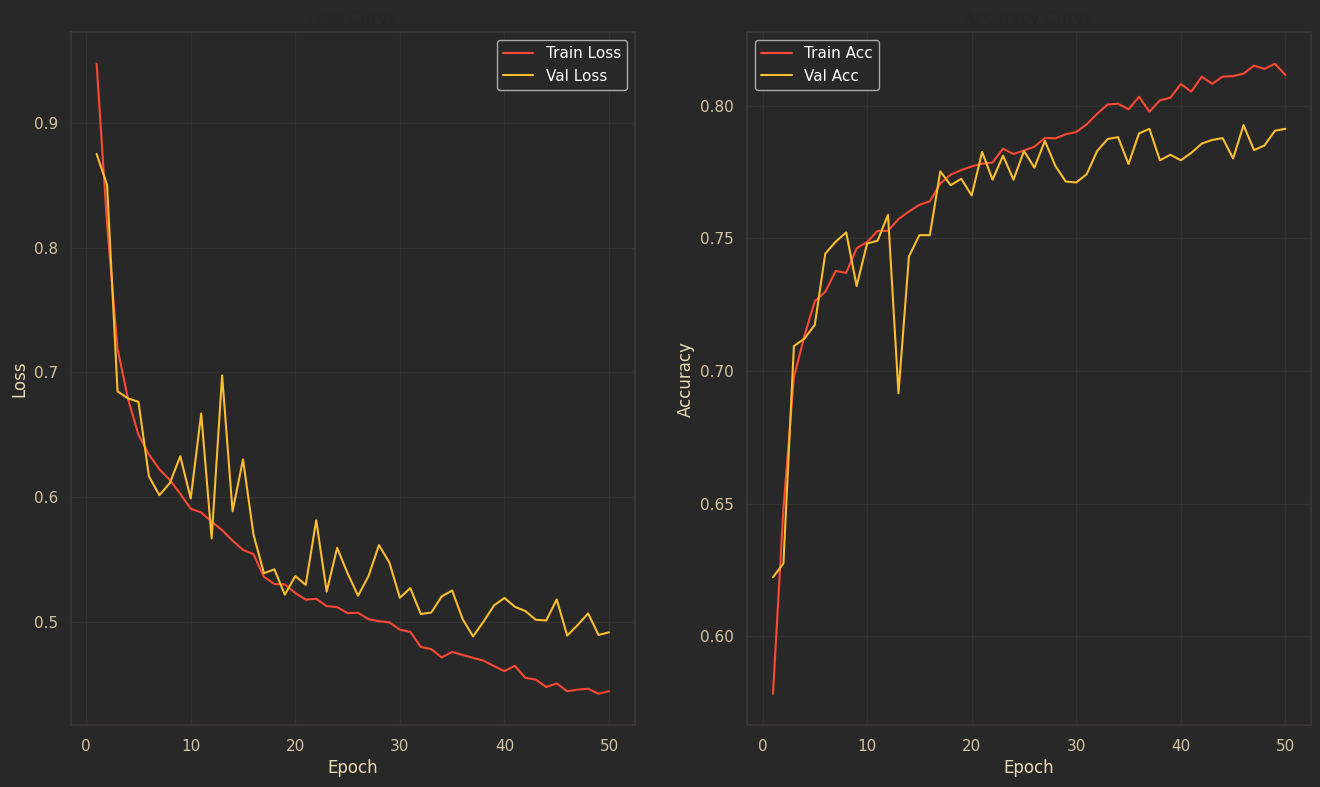

In [90]:
epochs = range(1, num_epochs+1)

# Loss curve
plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend( labelcolor='white')

# Accuracy curve
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend( labelcolor='white')

plt.show()

findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font family 'arial' not found.
findfont: Font f

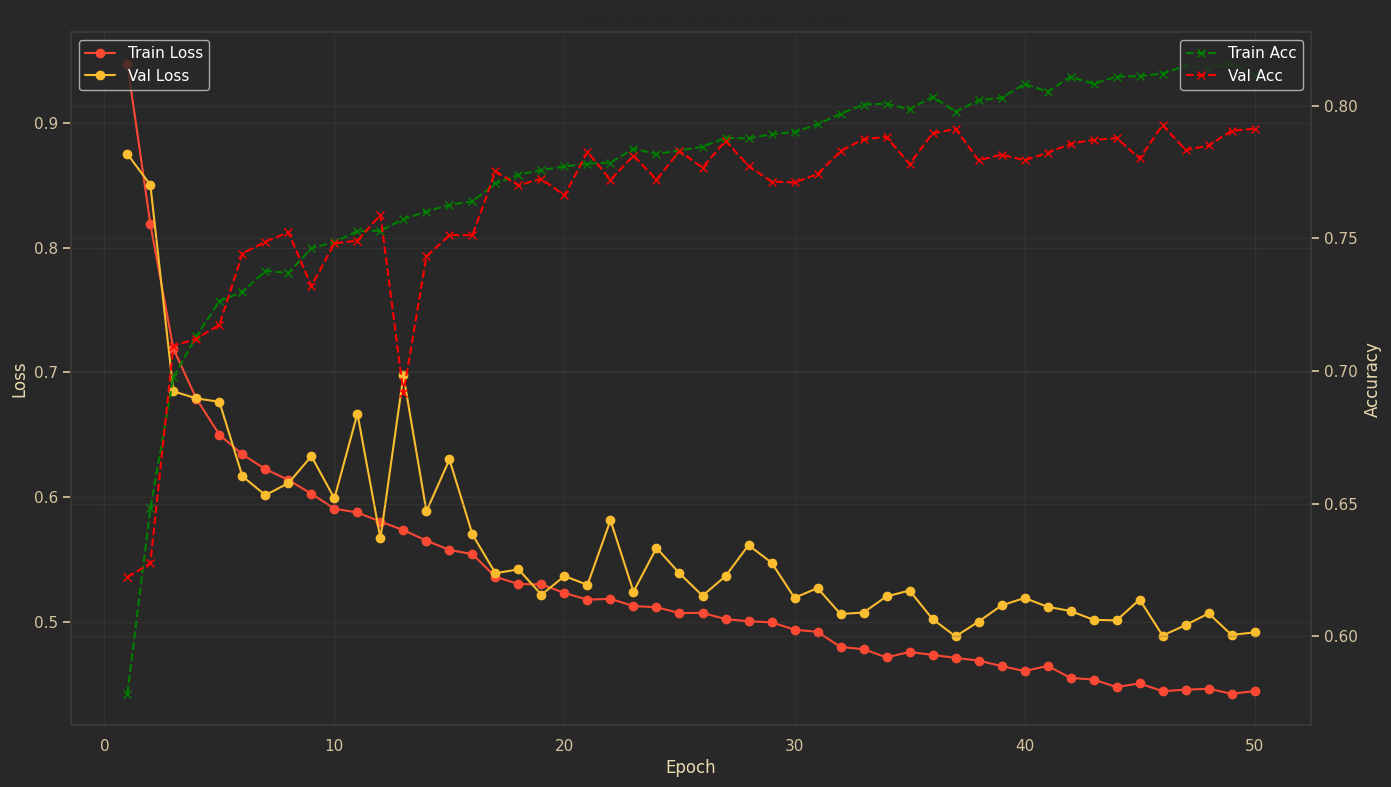

In [91]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def plot_fer_training_curves(log_dir="/kaggle/working/runs/mimic_exp1"):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # Scalars
    train_loss_events = event_acc.Scalars('Loss/train')
    val_loss_events = event_acc.Scalars('Loss/val')
    train_acc_events = event_acc.Scalars('Accuracy/train')
    val_acc_events = event_acc.Scalars('Accuracy/val')

    # Steps (x-axis = epoch number)
    epochs = [e.step+1 for e in train_loss_events]  # assuming step=epoch index starting from 0

    # Values
    train_loss = [e.value for e in train_loss_events]
    val_loss   = [e.value for e in val_loss_events]
    train_acc  = [e.value for e in train_acc_events]
    val_acc    = [e.value for e in val_acc_events]

    # Create figure
    fig, ax1 = plt.subplots(figsize=(16,9))

    # Loss curves
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(epochs, train_loss, label="Train Loss", marker='o')
    ax1.plot(epochs, val_loss, label="Val Loss", marker='o')
    ax1.legend(loc='upper left',  labelcolor='white')

    # Accuracy on secondary axis
    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    ax2.plot(epochs, train_acc, label="Train Acc", linestyle='--', marker='x', color='green')
    ax2.plot(epochs, val_acc, label="Val Acc", linestyle='--', marker='x', color='red')
    ax2.legend(loc='upper right',  labelcolor='white')

    plt.title("FER CNN Training & Validation Curves")
    plt.show()

# Call the function
plot_fer_training_curves()